# 1. Import libraries and dataset

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
import string # Contains punctuation and other string aspects
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
df = pd.read_csv("latest_dataset_2208")

# 2. EDA

In [132]:
# shape of dataset (rows, columns)
df.shape

(2439, 14)

In [133]:
# datatypes of each columns
df.dtypes

Unnamed: 0            int64
Title                object
URL                  object
Genres               object
Tags                 object
Description          object
Score               float64
Users Scored          int64
Episodes              int64
Cast                 object
Content Rating       object
Original Network     object
Director             object
Screenwriter         object
dtype: object

In [134]:
# drop unwanted columns
df.drop(columns= 'Unnamed: 0', inplace= True)

In [135]:
# number of unique values in each column
df.nunique()

Title               2373
URL                 2439
Genres               692
Tags                2143
Description         2325
Score                 28
Users Scored        1664
Episodes             158
Cast                2407
Content Rating         6
Original Network     127
Director             905
Screenwriter         773
dtype: int64

In [136]:
# check for duplicated values
df.duplicated().value_counts()

False    2439
dtype: int64

# EDA - Visualisations

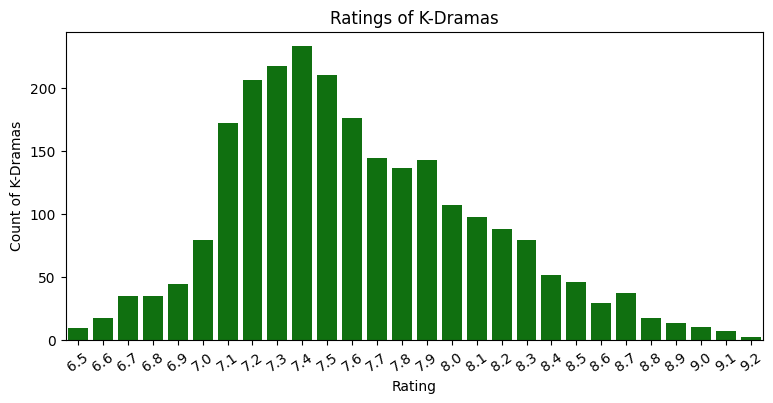

In [194]:
plt.figure(figsize = (9,4)) # setting the size of the output

sns.countplot( data = df,
             x = 'Score',

             color ='green') # setting the colours
            #order=df['Score'].value_counts().index) # https://www.statology.org/seaborn-countplot-order/
plt.xticks(rotation = 35)
plt.title('Ratings of K-Dramas')
plt.ylabel('Count of K-Dramas')
plt.xlabel('Rating')
plt.show()

### To provide better recommendations, a new dataset is created to include only dramas that has a score of 7.5 and above

In [138]:
filtered_df = df[df['Score'] >= 7.5]

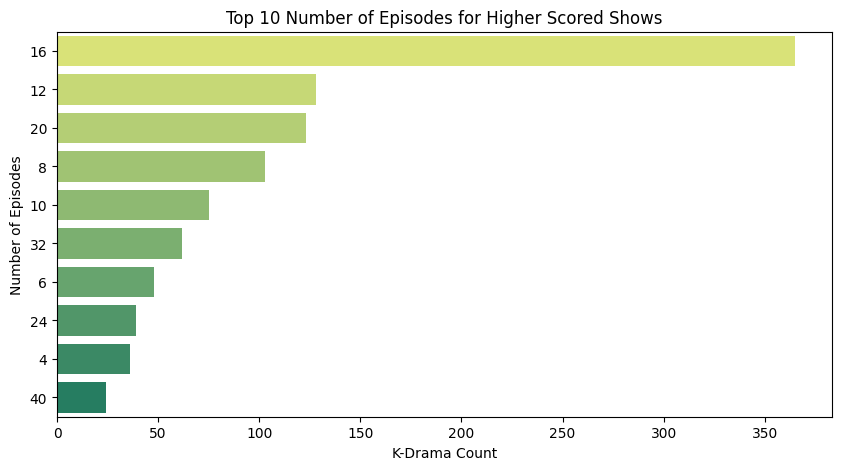

In [139]:
plt.figure(figsize=(10, 5))

sns.countplot(data=filtered_df,
              y='Episodes',

              palette='summer_r',  # setting the colours
              order= filtered_df['Episodes'].value_counts().head(10).index)  # https://www.statology.org/seaborn-countplot-order/

plt.title('Top 10 Number of Episodes for Higher Scored Shows')
plt.ylabel('Number of Episodes')
plt.xlabel('K-Drama Count')
plt.show()

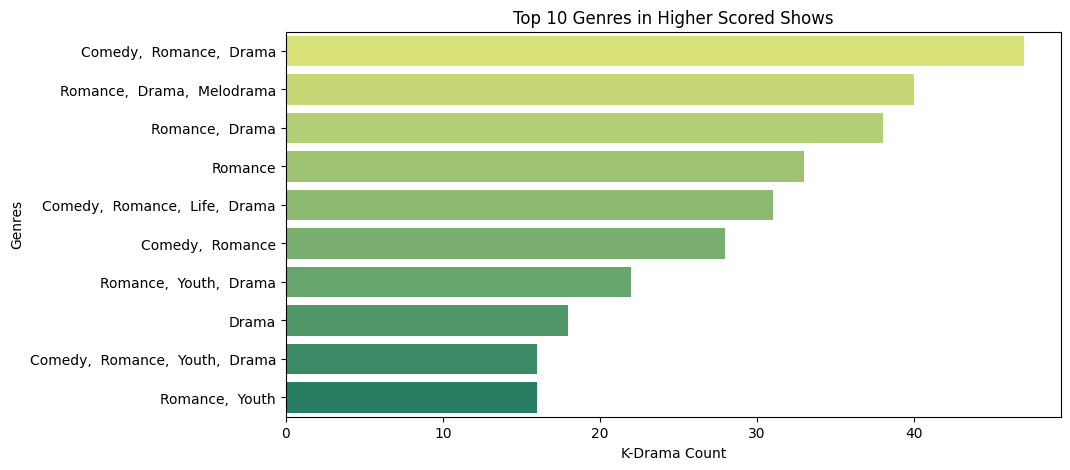

In [140]:
plt.figure(figsize=(10, 5))

sns.countplot(data=filtered_df,
              y='Genres',

              palette='summer_r',  # setting the colours
              order=filtered_df['Genres'].value_counts().head(10).index)  # https://www.statology.org/seaborn-countplot-order/

plt.title('Top 10 Genres in Higher Scored Shows')
plt.ylabel('Genres')
plt.xlabel('K-Drama Count')
plt.show()

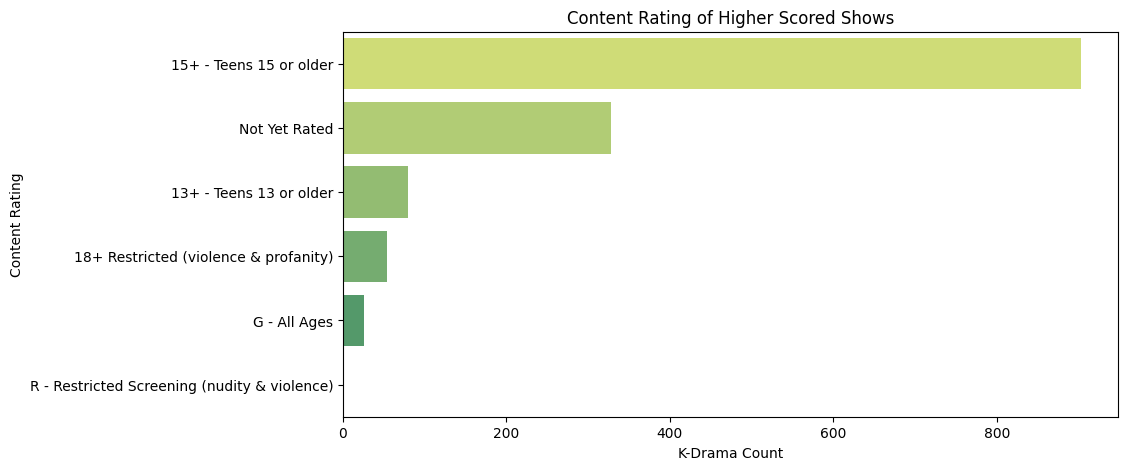

In [141]:
plt.figure(figsize=(10, 5))

sns.countplot(data=filtered_df,
              y='Content Rating',

              palette='summer_r',  # setting the colours
              order=filtered_df['Content Rating'].value_counts().index)  # https://www.statology.org/seaborn-countplot-order/

plt.title('Content Rating of Higher Scored Shows')
plt.ylabel('Content Rating')
plt.xlabel('K-Drama Count')
plt.show()

# 3. Data Cleaning and Pre-Processing

In [142]:
df1 = filtered_df.copy()

In [ ]:
# view kdramas that have no descriptions
df1[df1['Description'] == 'Unknown']

*   ### Dropping the kdramas with unknown descriptions as they have a low impact on the overall data.




In [144]:
# listing the titles for future reference
titles_w_no_desc = list(df1.loc[df1['Description'] == 'Unknown', 'Title'].str.lower())

In [145]:
df1 = df1[df1['Description'] != 'Unknown']

In [146]:
df1[df1['Description'] == 'Unknown']

,Title,URL,Genres,Tags,Description,Score,Users Scored,Episodes,Cast,Content Rating,Original Network,Director,Screenwriter


*   ### Creating a new column for clustering attrubutes






In [147]:
df1['clustering_attributes'] = (df1['Description'] + ' ' + df1['Genres'] + ' ' + df1['Tags'])

In [ ]:
# make column unicode
df1['clustering_attributes'].values.astype("U")

*   ### Removing unimportant words


1.   English stopwords from NLTK library
2.   Punctuations
3. Romanised Korean Syllables
4. Additional stopwords








In [149]:
# common romanised korean syllables usually found in korean names
common_korean_names = 'dae hui seok beok yeo hyung san dam jong park chul geu roo shi hee eun yoo baek jae sang woo woong geon wook ho gi na sool seon goo kyung hyuk dong seung joon kwon shin hwa yeong seo yeon jun soon sung yang myung gil bin gwang hoon hae rin chan sook cha ho suh yul moo yung yong young chan  suk guk yul kim lee yi choi jung jeong kang cho jo yoon jang lim hong shik min hye jin soo hyun tae hyo han joo chae '

In [150]:
# making it into a list
common_korean_names = common_korean_names.split()
common_korean_names = [token.strip() for token in common_korean_names]

In [151]:
# utilising stopwords from the nltk library and adding other important words and punctuations to the list
stpwrd = nltk.corpus.stopwords.words('english')
additional_stopwords = ['unknown', 'also', 'lead', 'mydramalist', "n't", 'source', 'viki', 'asianwiki',
                        'mbc', 'kbs' ,'dramawiki', 'naver', 'hancinema', 'soompi', 'sbs', 'netflix',
                        'disney', 'jtbs', 'tvn']
stpwrd.extend(additional_stopwords)
stpwrd.extend(string.punctuation)
stpwrd.extend(common_korean_names)

In [152]:
# creating a new column - clustering attributes column tokenised
df1['tokens'] = df1['clustering_attributes'].apply(word_tokenize)

In [153]:
# stripping the tokens
df1['tokens'] = df1['tokens'].apply(lambda document : [token.strip() for token in document])

In [154]:
# creating a function to preprocess data
def prep_data(text):

    '''a function for removing the stopwords and lemmatizing the words'''

    # removing the stop words and lowercasing the selected words
    words  = [word.lower() for word in text if word.lower() not in stpwrd]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # joining the list of words with space separator
    return words

In [155]:
df1['tokens'] = df1['tokens'].apply(prep_data)

In [156]:
# excluding words that have less than 3 characters
df1['tokens'] = df1['tokens'].apply(lambda document : [token for token in document if len(token)>2])

In [157]:
# creating a function to transform lists into a string

def listToString(s):
    ''' a function to join elements in a list into a single string'''
    # initialize an empty string
    str1 = " "

    # return string
    return (str1.join(s))

In [158]:
df1['tokens'] = df1['tokens'].apply(listToString)

In [159]:
df1['tokens']

0       autistic 20-year-old work father business move...
1       model student rank top high school physically ...
2       everyday extraordinary five doctor patient ins...
3       although hiding dark secret surrounding true i...
4       story people going day seemingly ordinary actu...
                              ...                        
2018    drama depicts love father family relationship ...
2020    successful drama writer scarred past father af...
2021    drama telling historical event scholar central...
2024    drama adopted woman struggle make family roman...
2235    drama based popular portrayal event time princ...
Name: tokens, Length: 1341, dtype: object

## Vectorization



In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [161]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df1['tokens'])

In [162]:
features.shape

(1341, 9417)

In [163]:
type(features)

scipy.sparse._csr.csr_matrix

In [164]:
features = features.toarray()

## Reducing dimensionality



*   Dimensionality reduction is used to simplify and improve the quality of data, making it more manageable for analysis and modeling




In [165]:
from sklearn.decomposition import PCA

In [166]:
pca = PCA(random_state=42)
pca.fit(features)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

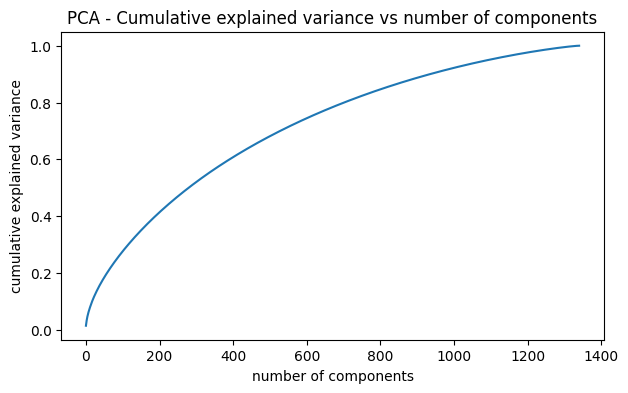

In [167]:
# Explained variance for different number of components
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

*   ### More than 80% of variance is explained just by 750 components








In [168]:
pca = PCA(n_components=750,random_state=42)
pca.fit(features)

PCA(n_components=750, random_state=42)

In [169]:
features_pca = pca.transform(features)

In [170]:
features_pca.shape

(1341, 750)

# 4. K-Means Clustering



*   To group K-Dramas into clusters
*   Optimal number of clusters are to be decided by the elbow method and the silhouette coefficient







## Elbow Method

In [ ]:
# elbow method

distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 42)
    kmeanModel.fit(features_pca)
    distortions.append(kmeanModel.inertia_)

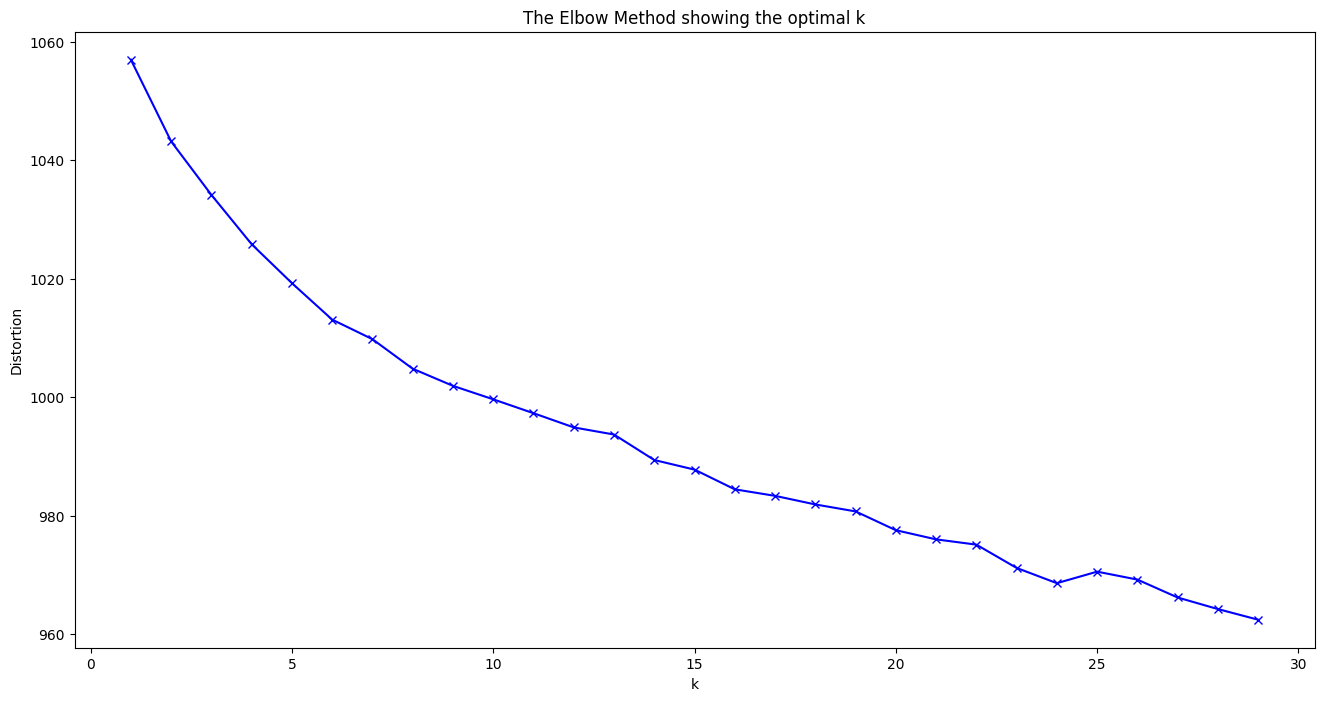

In [172]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Silhoutte Coefficient

In [173]:
# silhoutte coefficient

from sklearn.metrics import silhouette_score

In [ ]:
k_range = range(2,30) ## Look up between K=2 and K=30 clusters
scores = [] ## Save the silhouette scores
inertia = [] ## Save the inertia scores

for k in k_range:
    ''' Run K-means models and store their respective inertia scores and silhouette scores '''
    km3 = KMeans(n_clusters=k, random_state= 42) ## Keep the random state constant!
    km3.fit(features_pca) ## Fit it on the scaled data
    scores.append(silhouette_score(features_pca, km3.labels_)) ## Append the silhouette
    inertia.append(km3.inertia_) ## Append the inert

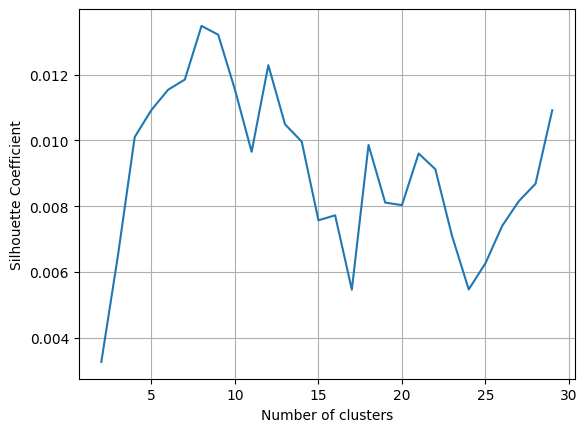

In [175]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [176]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(features_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

In [177]:
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(features_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(1004.7740282855507, 0.013488194968624858)




*   ### Optimal number of clusters is 8
*   ### Silhoutte coefficient of 0.0135 is relatively low, suggesting that the custers are not well formed.


*   ### However, we shall continue with this value and allow room for improvement in the future






In [178]:
df1['kmeans_cluster'] = kmeans.labels_

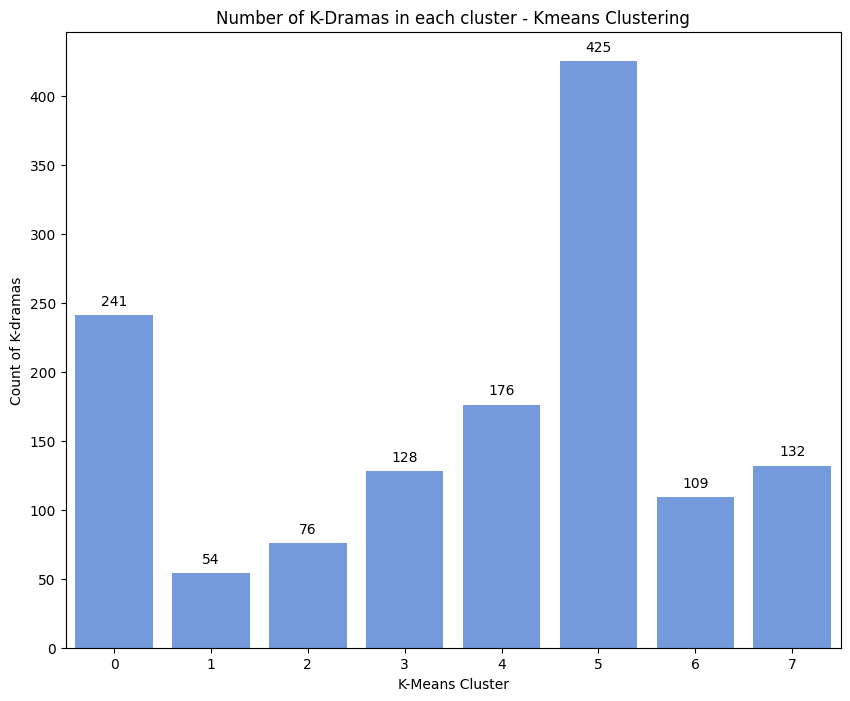

In [179]:
# plotting the number of kdramas in each kmeans cluster
plt.figure(figsize=(10,8))
q = sns.countplot(x='kmeans_cluster',data=df1, color = 'cornflowerblue')
plt.title('Number of K-Dramas in each cluster - Kmeans Clustering')
plt.xlabel('K-Means Cluster')
plt.ylabel('Count of K-dramas')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Wordclouds for Each Cluster

In [180]:
def kmeans_worldcloud(cluster_num):

  ''' function to create wordclouds for each cluster'''

  comment_words = ''
  stopwords = stpwrd
  # iterate through the csv file
  for val in df1[df1['kmeans_cluster']==cluster_num].Description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      # Filter out tokens with lengths less than or equal to 2
      filtered_tokens = [token for token in tokens if len(token) > 2]

      comment_words += " ".join(filtered_tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

cluster:0
cluster:1
cluster:2
cluster:3
cluster:4
cluster:5
cluster:6
cluster:7


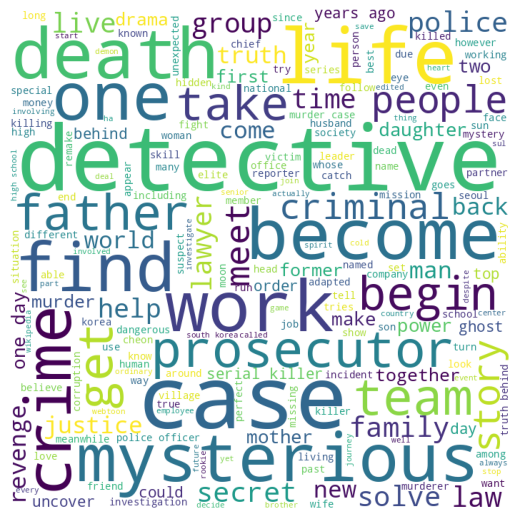

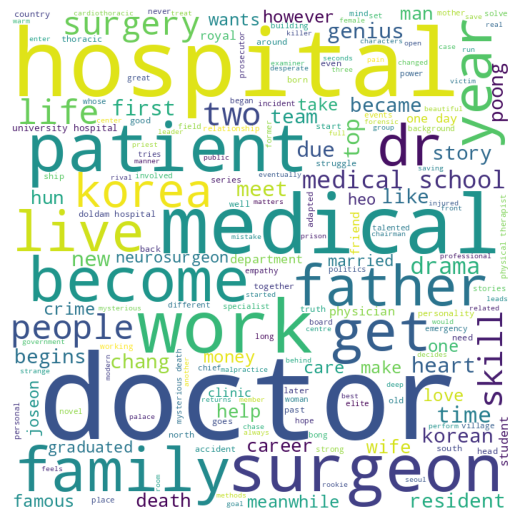

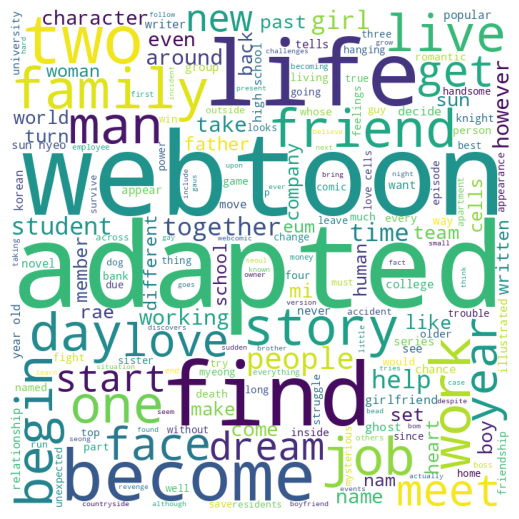

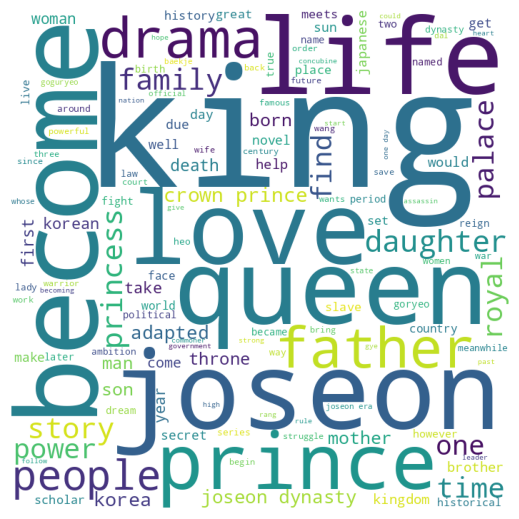

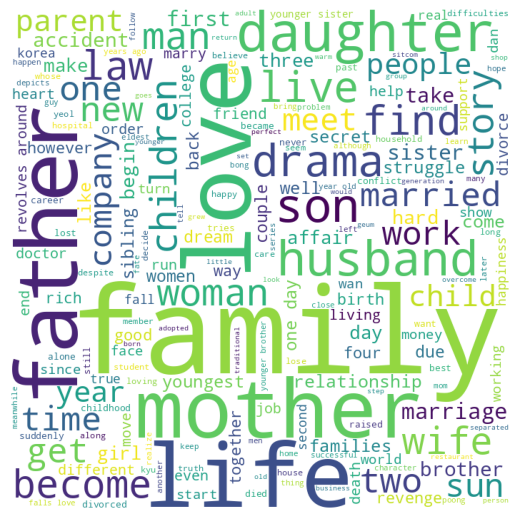

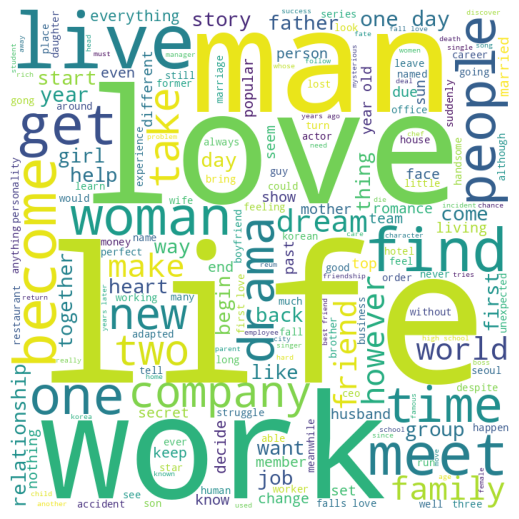

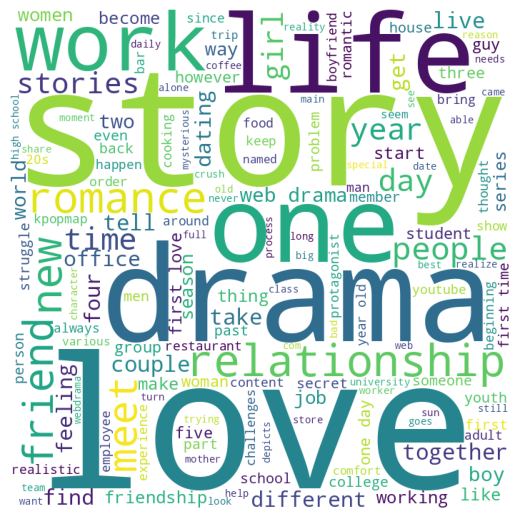

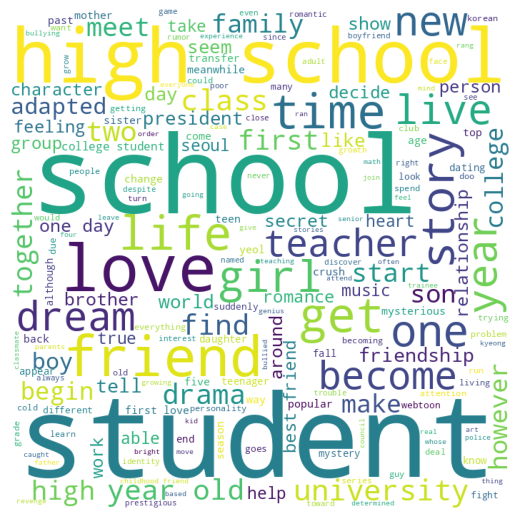

In [181]:
for i in range(8):
  print('cluster:' + str(i) )
  kmeans_worldcloud(i)

## Plotting K-Means Clusters

In [ ]:
y_kmeans = kmeans.fit_predict(features_pca)

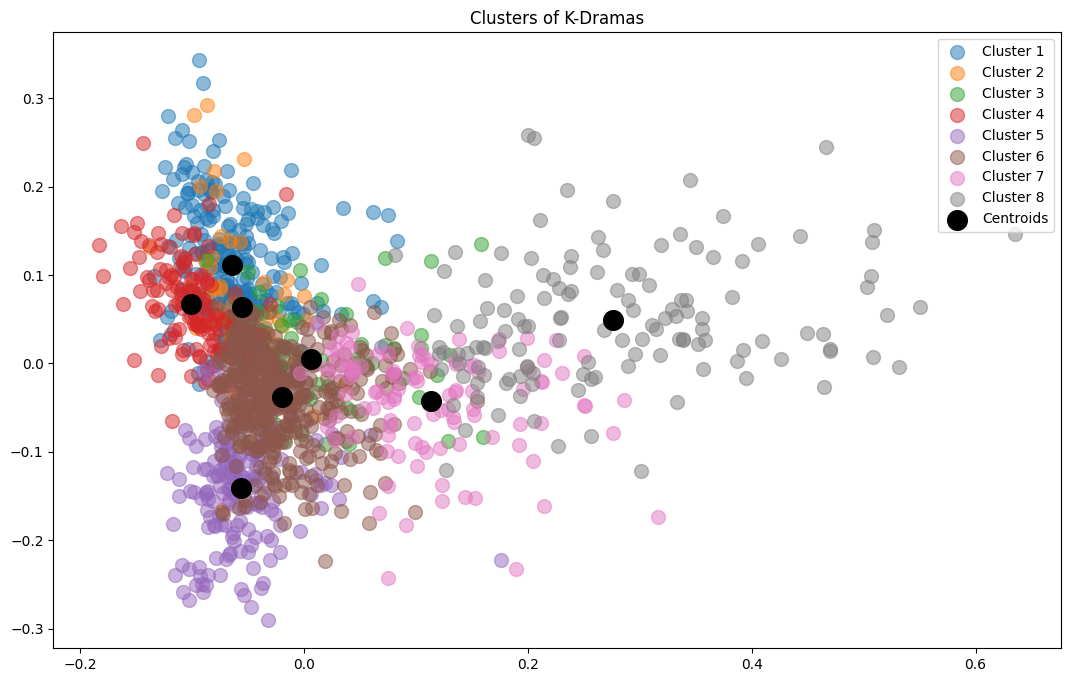

In [183]:
num_clusters = 8

plt.figure(figsize=(13, 8))

for cluster_idx in range(num_clusters):
    plt.scatter(
        features_pca[y_kmeans == cluster_idx, 0],
        features_pca[y_kmeans == cluster_idx, 1],
        s=100,
        label=f'Cluster {cluster_idx + 1}',
        alpha=0.5
    )

plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c='black',
    label='Centroids'
)

plt.title('Clusters of K-Dramas')
plt.legend()
plt.show()

# 5. Recommendation System

In [184]:
recommender_df = df1.copy()

In [185]:
recommender_df["Title"] = recommender_df["Title"].str.lower()

In [186]:
recommender_df.set_index('Title',inplace=True)

In [187]:
indices = pd.Series(recommender_df.index)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def recommend_5():

    ''' a function to recommend users similar k-dramas to the ones they have inputted'''

    while True:

      print('Please enter the K-Drama you want recommendations on or enter -1 if you would like to cancel.')
      title = input()
      if title == '-1':
        break
      title_lower = title.lower()
      if title_lower in titles_w_no_desc:
        print('Sorry, we do not have enough information on this K-Drama. Please input a different title.')
      else:
        try:
            recommend_content = [] # empty list for recommended titles

            input_cluster = recommender_df.loc[title_lower, "kmeans_cluster"]

            CV = CountVectorizer()
            converted_matrix = CV.fit_transform(recommender_df['tokens'])
            cosine_sim = cosine_similarity(converted_matrix)

            idx = recommender_df.index.get_loc(title_lower)
            series = pd.Series(cosine_sim[idx])
            similarities_with_cluster = zip(series, recommender_df.index, recommender_df["kmeans_cluster"])
            sorted_similarities_with_cluster = sorted(similarities_with_cluster, key=lambda x: x[0], reverse=True)

            # Appending dictionaries with movie information from the same cluster
            for similarity, kdrama_index, cluster in sorted_similarities_with_cluster:
                if cluster == input_cluster and kdrama_index != title_lower:
                    recommended_movie = {
                        "Title": kdrama_index.title(),
                        "Description": recommender_df.loc[kdrama_index, "Description"],
                        "Genre": recommender_df.loc[kdrama_index, "Genres"],
                        "Tags": recommender_df.loc[kdrama_index, "Tags"],
                        "URL": recommender_df.loc[kdrama_index, "URL"],
                        "Similarity": similarity,
                        "Cluster": recommender_df.loc[kdrama_index, "kmeans_cluster"]
                    }
                    recommend_content.append(recommended_movie)

            # Display recommendations
            print(f"If you liked '{title.title()}', you may also enjoy these: \n")
            recommended_df = pd.DataFrame(recommend_content)
            return recommended_df.head(5)

        except:
            print('Invalid entry. Movie title not in system. Please input a different title')

In [191]:
recommend_5()

Please enter the K-Drama you want recommendations on or enter -1 if you would like to cancel.
our beloved summer
If you liked 'Our Beloved Summer', you may also enjoy these: 



,Title,Description,Genre,Tags,URL,Similarity,Cluster
0,Reply 1997,"Set in the 1990s, the drama centers around a f...","Comedy, Romance, Life","High School, 1990s, First Love, Friends To Lov...",https://mydramalist.com/4689-reply-1997,0.492330,7
1,My First First Love Season 2,“My First First Love” is a romantic coming-of-...,"Comedy, Romance, Life, Youth","Friends To Lovers, Coming Of Age, First Love, ...",https://mydramalist.com/37561-my-first-first-l...,0.405774,7
2,All That We Loved,Depicts the solid friendship and sincere love ...,"Romance, Youth","Student Female Lead, Student Male Lead, School...",https://mydramalist.com/724633-love-do-it,0.405314,7
3,The World Of My 17 Season 2,"""18 years old, will Na Ri have her first love?...","Youth, Drama","Student Supporting Character, Student Female L...",https://mydramalist.com/708001-the-world-of-my...,0.403587,7
4,My Strange Hero,"When Kang Bok Soo was a high school student, h...","Mystery, Comedy, Romance, Youth","Student-Teacher Relationship, Corruption, Seco...",https://mydramalist.com/30767-revenge-is-back,0.402458,7
